In [1]:
import os
from PIL import Image
import argparse
import cv2
import torch
import numpy as np
import glob
from torch.cuda import amp
from tqdm import tqdm
import sys

sys.path.append("/home/aihao/workspace")
from anime_segmentation.train import AnimeSegmentation, net_names

In [2]:
def get_mask(model, input_img, use_amp=True, s=640):
    input_img = (input_img / 255).astype(np.float32)
    h, w = h0, w0 = input_img.shape[:-1]
    h, w = (s, int(s * w / h)) if h > w else (int(s * h / w), s)
    ph, pw = s - h, s - w
    img_input = np.zeros([s, s, 3], dtype=np.float32)
    img_input[ph // 2 : ph // 2 + h, pw // 2 : pw // 2 + w] = cv2.resize(
        input_img, (w, h)
    )
    img_input = np.transpose(img_input, (2, 0, 1))
    img_input = img_input[np.newaxis, :]
    tmpImg = torch.from_numpy(img_input).type(torch.FloatTensor).to(model.device)
    with torch.no_grad():
        if use_amp:
            with amp.autocast():
                pred = model(tmpImg)
            pred = pred.to(dtype=torch.float32)
        else:
            pred = model(tmpImg)
        pred = pred.cpu().numpy()[0]
        pred = np.transpose(pred, (1, 2, 0))
        pred = pred[ph // 2 : ph // 2 + h, pw // 2 : pw // 2 + w]
        pred = cv2.resize(pred, (w0, h0))[:, :, np.newaxis]
        return pred


In [3]:
model = AnimeSegmentation.try_load(
    "isnet_is",
    "/home/aihao/workspace/DeepLearningContent/models/anime-seg/isnetis.ckpt",
    "cuda",
    img_size=1024,
)
model.eval()
model.to("cuda")

AnimeSegmentation(
  (net): ISNetDIS(
    (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (rebnconv1): REBNCONV(
        (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_s1): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.

In [4]:
image_folder="../validation_images/3"

In [7]:
img = cv2.cvtColor(
    cv2.imread(os.path.join(image_folder, "1_origin.png"), cv2.IMREAD_COLOR),
    cv2.COLOR_BGR2RGB,
)
mask = get_mask(model, img, use_amp=False, s=1024)
img = np.concatenate((mask * img + 1 - mask, mask * 255), axis=2).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(os.path.join(image_folder, "1.png"), img)

True

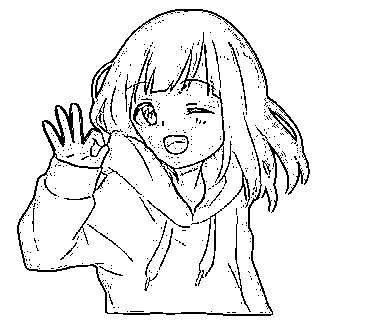

In [8]:
img = cv2.cvtColor(
    cv2.imread(os.path.join(image_folder, "2_origin.png"), cv2.IMREAD_COLOR),
    cv2.COLOR_BGR2RGB,
)
mask = get_mask(model, img, use_amp=False, s=1024)
img = np.concatenate((mask * img + 1 - mask, mask * 255), axis=2).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
img = cv2.adaptiveThreshold(
    img,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    blockSize=5,
    C=7,
)
img = Image.fromarray(img).convert("RGB")
img.save(os.path.join(image_folder, "2.png"))
img